# import Packages

In [ ]:
import pandas as pd
import cupy as cp
import numpy as np
import os

import random
import math
from scipy.optimize import curve_fit # Use non-linear least squares to fit a function - for the zenith angle calculation
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa

## available GPU and set memory growth
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## set random seed to reproduce result
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
train = pd.read_csv('./data/train/train.csv')

print(train.shape)
train.head()

(52560, 9)


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [6]:
train.describe()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
count,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000,52560.000000
mean,547.000000,11.500000,15.000000,64.344121,234.792371,2.456033,56.793102,9.279928,17.790630
std,316.102148,6.922252,15.000143,103.897125,349.684583,1.426874,22.052875,10.179741,25.759955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.590000,-19.000000,0.000000
25%,273.000000,5.750000,0.000000,0.000000,0.000000,1.400000,39.697500,1.000000,0.000000
50%,547.000000,11.500000,15.000000,0.000000,0.000000,2.200000,57.600000,9.000000,0.000000
75%,821.000000,17.250000,30.000000,87.000000,469.000000,3.200000,72.770000,17.000000,32.089890
max,1094.000000,23.000000,30.000000,528.000000,1059.000000,12.000000,100.000000,35.000000,99.913939


In [7]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

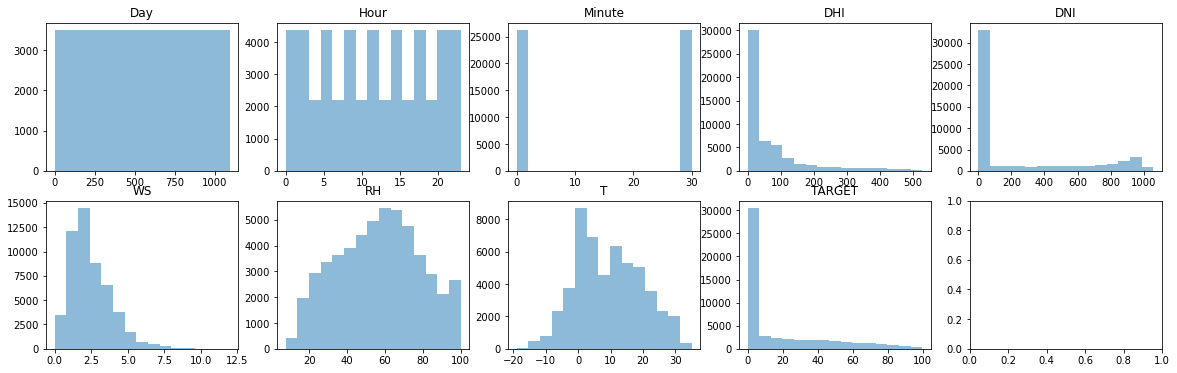

In [10]:
fig, ax = plt.subplots(2, train.shape[1]//2+1, figsize=(20, 6))
for idx, feature in enumerate(train.columns):
    data = train[feature]
    if idx<train.shape[1]//2 + 1:
        ax[0,idx].hist(train.iloc[:,idx], bins=15, alpha=0.5)
        ax[0,idx].set_title(train.columns[idx])
    else:
        ax[1,idx-train.shape[1]//2-1].hist(train.iloc[:,idx], bins=15, alpha=0.5)
        ax[1,idx-train.shape[1]//2-1].set_title(train.columns[idx])
plt.show()

## Target 에 대한 feature 상관 관계

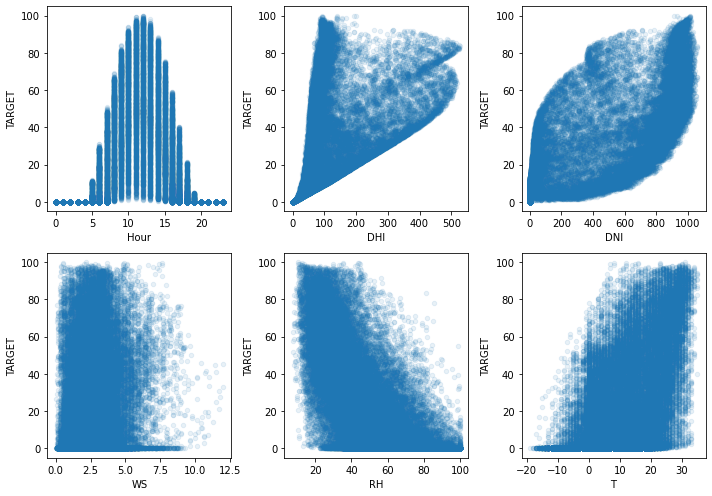

In [11]:

fig, axes = plt.subplots(2, 3, figsize=(10,7))
train.plot(x='Hour', y='TARGET', kind='scatter', alpha=0.1, ax=axes[0,0])
train.plot(x='DHI', y='TARGET', kind='scatter', alpha=0.1, ax=axes[0,1])
train.plot(x='DNI', y='TARGET', kind='scatter', alpha=0.1, ax=axes[0,2])
train.plot(x='WS', y='TARGET', kind='scatter', alpha=0.1, ax=axes[1,0])
train.plot(x='RH', y='TARGET', kind='scatter', alpha=0.1, ax=axes[1,1])
train.plot(x='T', y='TARGET', kind='scatter', alpha=0.1, ax=axes[1,2])

fig.tight_layout()

## 전처리

In [15]:
def transform(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

x_col =['DHI','DNI','WS','RH','T','TARGET']
y_col = ['TARGET']

dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

past_history = 48 * 7
future_target = 48 * 2

### transform train
train_data, train_label = transform(dataset, label, 0,None, past_history,future_target, 1)
### transform test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'data/test/{i}.csv')
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

## 모델 학습 및 예측

In [ ]:
# 장인 정신으로 파라미터 튜닝

from sklearn import ensemble
rf = ensemble.RandomForestRegressor(
                                    n_estimators=2150,
                                    max_features='auto', random_state=0,
                                    max_depth = 13,
                                    oob_score=True,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)

In [ ]:
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(test))
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    submission.iloc[:, i] = np.ravel(y_pred)

In [ ]:
# submission 생성
submission.to_csv(f'submission_2150_13_.csv') 

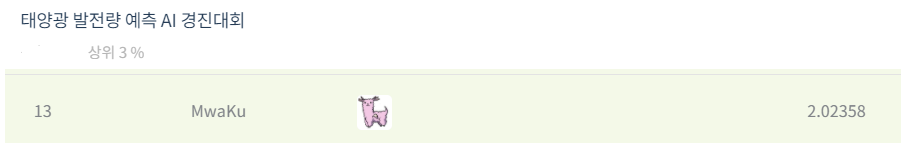

In [16]:
from IPython.core.display import Image
from IPython.display import Image
Image('./data/순위.png')